### *Variables Générales et Imports*

In [28]:
import urllib.request
import os
import json
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.cluster import KMeans
from PIL import Image


QUERY_LIMIT = 5
DATA_JSON_PATH = "data.json"
USERS_JSON_PATH = "users.json"

## Collecte de données

### Fonctions

In [2]:
def getDataFrame(JSON):
    columns   = ["label","format","link","path"]
    dataArray = []
    for data in JSON["results"]["bindings"]:
        link = data["image"]["value"]
        label = data["itemLabel"]["value"]
        format = str(link).split(".")[-1]
        path = "./images/" + label +"."+ format

        dataArray.append([label,format,link,path])


    return pd.DataFrame(dataArray, columns= columns)

### Collecte des images

In [3]:
# Récupération de la Query
url = "https://query.wikidata.org/sparql?query=SELECT%20%3Fitem%20%3FitemLabel%20%3Fimage%0AWHERE%0A%7B%0A%3Fitem%20wdt%3AP31%20wd%3AQ144%20.%0A%3Fitem%20wdt%3AP18%20%3Fimage%0ASERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22%20%7D%0A%7D%0ALIMIT%20"+str(QUERY_LIMIT)+"&format=json"
response = urllib.request.urlopen(url)
responseJSON  = json.load(response)

# Création de la dataframe
dataframe = getDataFrame(responseJSON)



# Vidage du dossier images
files = glob.glob('./images/*')
for f in files:
    os.remove(f)

sizes = []
# Telechargement des images
length = len(dataframe.index)
for i in range(length):
    link = dataframe._get_value(i,'link')
    path = dataframe._get_value(i,'path')
    urllib.request.urlretrieve(link, path)

    img = Image.open(path)
    sizes.append(np.array(img.size))
    img.close()

dataframe["résolution"] = sizes

# Création du fichier JSON 
file = open(DATA_JSON_PATH, "w") 
file.write(dataframe.to_json())
file.close()

dataframe

,label,format,link,path,résolution
0,Old Hemp,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Old Hemp.jpg,"[1000, 859]"
1,Endal,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Endal.jpg,"[1312, 2000]"
2,Gabi,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Gabi.jpg,"[2032, 1524]"
3,Gunner,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Gunner.jpg,"[300, 458]"
4,Haymarket Faultless,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Haymarket Faultless.jpg,"[180, 181]"


### Récupération des Métadonnées EXIF

In [4]:
dataframe = pd.read_json(DATA_JSON_PATH)

tags = ["label","model"]
tagsWantedEXIF = [272]
dataEXIF = []
    
length = len(dataframe.index)
for i in range(length):
    path = dataframe._get_value(i,'path')
        
    image = Image.open(path)
    exif = image.getexif()

        

    array = [dataframe._get_value(i,'label')]
    for tag in tagsWantedEXIF:
        array.append(exif.get(tag))
    dataEXIF.append(array)
    
dataframeEXIF = pd.DataFrame(dataEXIF, columns=tags)
for c in dataframeEXIF.columns :
    dataframe[c] = dataframeEXIF[c]
        
file = open(DATA_JSON_PATH, "w")
file.write(dataframe.to_json())
file.close()

dataframeEXIF

,label,model
0,Old Hemp,None
1,Endal,None
2,Gabi,KODAK CX7330 ZOOM DIGITAL CAMERA
3,Gunner,None
4,Haymarket Faultless,None


## Étiquetage et annotation

### Couleurs prédominantes

In [5]:
N = 3
resolution = 10

dataframe = pd.read_json(DATA_JSON_PATH)
meansArray = []

for path in dataframe.path:

    img = Image.open(path).convert("RGB")
    imgArray = np.array(img.getdata())[::10]
    img.close()
    imgDataframe = pd.DataFrame(imgArray, columns=["red","green","blue"])

    model=KMeans(n_clusters= N, n_init='auto')
    model.fit(imgDataframe)

    meansList = (np.floor(model.cluster_centers_)).tolist()
    meansArray.append(meansList)


columns = [ "color"+str(i+1) for i in range(N)]
meansDataframe = pd.DataFrame(meansArray,columns= columns)
for c in columns:
    dataframe[c] = meansDataframe[c]

# Création du fichier JSON 
colorTable = open(DATA_JSON_PATH, "w")
colorTable.write(dataframe.to_json())
colorTable.close()

meansDataframe



,color1,color2,color3
0,"[194.0, 173.0, 151.0]","[55.0, 44.0, 33.0]","[128.0, 111.0, 96.0]"
1,"[40.0, 38.0, 39.0]","[138.0, 126.0, 117.0]","[204.0, 192.0, 177.0]"
2,"[165.0, 157.0, 147.0]","[100.0, 88.0, 87.0]","[227.0, 222.0, 214.0]"
3,"[197.0, 197.0, 197.0]","[47.0, 47.0, 47.0]","[133.0, 133.0, 133.0]"
4,"[121.0, 76.0, 13.0]","[166.0, 135.0, 105.0]","[210.0, 206.0, 205.0]"


> ### Option : affichage des couleurs prédominantes

[[0.74117647 0.70588235 0.65490196]
 [0.59215686 0.5372549  0.47058824]
 [0.27843137 0.25098039 0.2       ]]


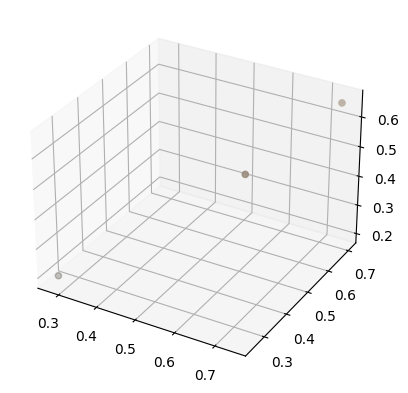

In [72]:
path = "./images/Mancs.jpg"

dataframe = pd.read_json(DATA_JSON_PATH)

inded = 0 
for i, line in enumerate(dataframe["path"]):
    if line == path:
        index = i

colors = np.array([dataframe["color"+str(i+1)][index] for i in range(N)])

x = [c[0]/255  for c in colors]
y = [c[1]/255  for c in colors]
z = [c[2]/255  for c in colors]
c = colors/255

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z,c = c)

### Orientation et Taille

In [6]:
dataframe = pd.read_json(DATA_JSON_PATH)

orientations = []
tailles = []
for taille in dataframe["résolution"]:
    # Orientation
    if taille[0] > taille[1]:
        orientations.append("paysage")
    else:
        orientations.append("portrait")
    
    nbrPixel = taille[0] * taille[1]
 
    if   nbrPixel >= 1920*1080:
        tailles.append("Grande")
    elif nbrPixel >= 1280*720:
        tailles.append("Moyenne")
    elif nbrPixel >= 720*480:
        tailles.append("Petite")
    else :
        tailles.append("Vignette")
    

dataframe["orientation"] = orientations
dataframe["taille"] = tailles

# Création du fichier JSON 
colorTable = open(DATA_JSON_PATH, "w")
colorTable.write(dataframe.to_json())
colorTable.close()


### Autres

In [7]:
dataframe = pd.read_json(DATA_JSON_PATH)

dataframe["tags"] = [[] for i in range(len(dataframe["label"]))]

colorTable = open(DATA_JSON_PATH, "w")
colorTable.write(dataframe.to_json())
colorTable.close()

## Analyse des données

#### Fonctions

In [23]:
def createUser(id : str):
    columns = ["id","colors","orientation","sizes","tags","imagesLiked"]
    row = [[id,[],None,[],[],[]]]
    newData = pd.DataFrame(row, columns= columns)

    try :
        userDataFrame = pd.read_json(USERS_JSON_PATH)
    except FileNotFoundError :
        userDataFrame = resetUsersDataFrame()
        
    if not (id in list(userDataFrame["id"])):
        userDataFrameChanged = pd.concat([userDataFrame,newData],ignore_index=True)
        saveUserDataFrame(userDataFrameChanged)
    else :
        print("User already exist")


def resetUsersDataFrame():
    columns = ["id","colors","orientation","sizes","tags","imagesLiked"]
    userDataFrame = pd.DataFrame(columns = columns)
    saveUserDataFrame(userDataFrame)
    return userDataFrame


def saveUserDataFrame(userDataFrame):
    usersJSON = open(USERS_JSON_PATH, "w")
    usersJSON.write(userDataFrame.to_json())
    usersJSON.close()


def affUserDataFrame():
    return pd.read_json(USERS_JSON_PATH)
    


### Création utilisateurs

In [24]:
createUser("john")
affUserDataFrame()

User already exist


,id,colors,orientation,sizes,tags,imagesLiked
0,john,[],NaN,[],[],[]


### Ajouter une image likée pour un utilisateur

TypeError: saveUserDataFrame() missing 1 required positional argument: 'userDataFrame'

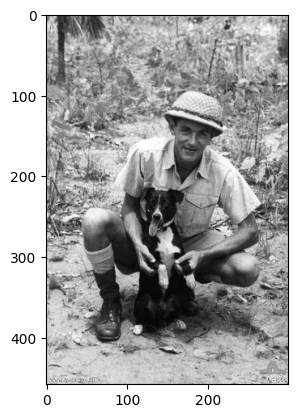

In [29]:
currentUser = "john"
poollSize = 5

dataDataFrame = pd.read_json(DATA_JSON_PATH)
userDataFrame = pd.read_json(USERS_JSON_PATH)

userId = ""
while not userId in list(userDataFrame["id"]) :
    userId = input("user Id :")

i = random.randint(0,len(dataDataFrame["label"]))
while i in userDataFrame["imagesLiked"][list(userDataFrame["id"]).index(userId)] :
    random.randint(0,len(dataDataFrame["label"]))

img = Image.open(dataDataFrame["path"][i]).convert('RGB')
img.show()

invalid = True
while invalid:
    ans = input("Do you like this image ? [y/n]").capitalize()
    invalid = ans not in ["Y","N"]
liked = ans == "Y"  
if liked :
    (userDataFrame["imagesLiked"][list(userDataFrame["id"]).index(userId)]).append(i)

saveUserDataFrame(userDataFrame)
